# Diffusivity

This notebook analyze the diffusivity based on the trajectory data.

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import trackpy as tp
from skimage import io
from corrLib import readdata
from xiaolei.chain.tracking import gauss1
from scipy.optimize import curve_fit
from myImageLib import bestcolor
# import dufte
plt.style.use('default')

## Load trajectory

In [7]:
folder = '/home/zhengyang/data/DE/07212021/2021-07-21_16h41m52s'
data = pd.read_csv(os.path.join(folder, 'crop_HoughCircles', 'xyz-traj.csv'))

In [11]:
t = data.assign(particle=0)

(-0.5, 424.5, 387.5, -0.5)

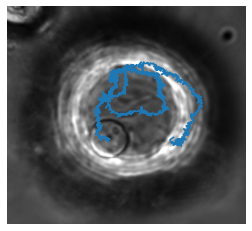

In [12]:
mpp = 0.16
l = readdata(folder, 'tif')
img = io.imread(l.Dir.iloc[0])
plt.figure()
plt.imshow(img, cmap='gray')
plt.plot(data.x/mpp, data.y/mpp)
plt.axis('off')

## 2D vs. 3D

In [168]:
msd = tp.msd(t, mpp=1, fps=30, max_lagtime=1500)
msd3 = tp.msd(t.dropna(), mpp=1, fps=30, max_lagtime=1500, pos_columns=['z', 'x', 'y'])

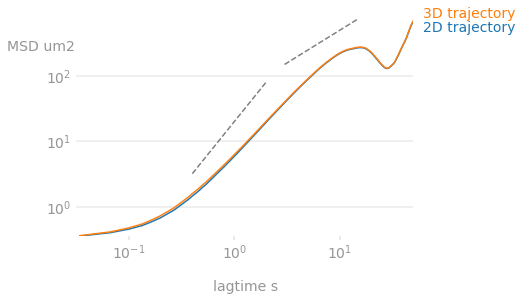

In [174]:
plt.plot(msd.lagt, msd.msd, label='2D trajectory')
plt.plot(msd3.lagt, msd3.msd, label='3D trajectory')

# plt.plot([1e-1, 60], [d**2, d**2], ls='--', color='gray', label='Diameter 5200')
plt.loglog()

x = np.array([.4, 2])
y = 20* x ** 2
plt.plot(x, y, color='gray', ls='--')

x = np.array([3, 15])
y =  50* x ** 1
plt.plot(x, y, color='gray', ls='--')
dufte.ylabel('MSD um2')
plt.xlabel('lagtime s')
dufte.legend()

**Comments:**
- Cristian's data shows ballistic regime at ~0.02 s, diffusive regime at ~1 s and subdiffusive (plateau) regime at ~10 s. To produce data that is comparable to his, longer video with higher frame rate is necessary (80 fps for 1000 s)
- In the video(0716/3), the outer droplet moves significantly. As a result, the motion of inner droplet is affected. For more accurate analysis, I need to track the outer droplet and subtract its motion from the inner's.
- 3D trajectory is obtained (0720/16h42m). 2D and 3D MSD's are compared. They are very similar in long time limit, indicating that Z-motion is weaker than XY-motion. 3D MSD is higher in short time limit, likely due to manual tracking error.

## MSD of different experiments

In [186]:
d = {} # traj data directories
d['50[23]11'] = '/home/zhengyang/data/DE/07212021/2021-07-21_16h41m52s/images/crop_HoughCircles/xyz-traj.csv'
d['72[32]8'] = '/home/zhengyang/data/DE/07202021/1st-drop-tracking/2021-07-20_16h42m46s/images/crop_HoughCircles/xyz-traj.csv'
d['100[20]34'] = '/home/zhengyang/data/DE/07132021/2021-07-13_17h17m24s/images/crop_HoughCircles/xyz-traj.csv'

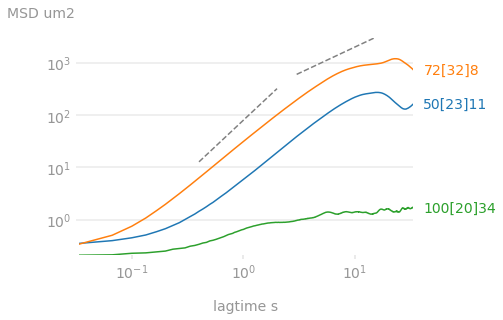

In [187]:
fig, ax = plt.subplots()
for kw in d:
    traj = pd.read_csv(d[kw]).assign(particle=0).rename(columns={'filename': 'frame'})
    msd = tp.msd(traj, mpp=1, fps=30, max_lagtime=1000)
    ax.plot(msd.lagt, msd.msd, label=kw)
ax.loglog()
dufte.legend()
dufte.ylabel('MSD um2')
ax.set_xlabel('lagtime s')

x = np.array([.4, 2])
y = 80* x ** 2
ax.plot(x, y, color='gray', ls='--')

x = np.array([3, 15])
y =  200* x ** 1
ax.plot(x, y, color='gray', ls='--')

## Displacement distribution (PDF)

### Minimal code

In [26]:
folder = '/home/zhengyang/data/DE/07202021/1st-drop-tracking/2021-07-20_16h42m46s/crop_HoughCircles'
traj = pd.read_csv(os.path.join(folder, 'xyz-traj.csv'))

<AxesSubplot:>

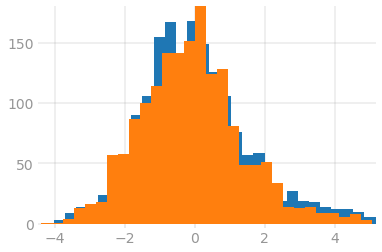

In [27]:
dx = traj.x.diff(10)
dy = traj.y.diff(10)
fig, ax = plt.subplots()
dx.hist(bins=30, ax=ax)
dy.hist(bins=30, ax=ax)

### Take 07202021 data for example

- This dataset contains 15 videos of the same DE system
- All the videos are taken at 30 fps for ~1 min
- Imaging begins at 16:24 and ends at 16:51

#### Compare different videos at same dt
- dt = 0.03, 0.33, 1, 3 are shown (1, 10, 30, 90 in frames)

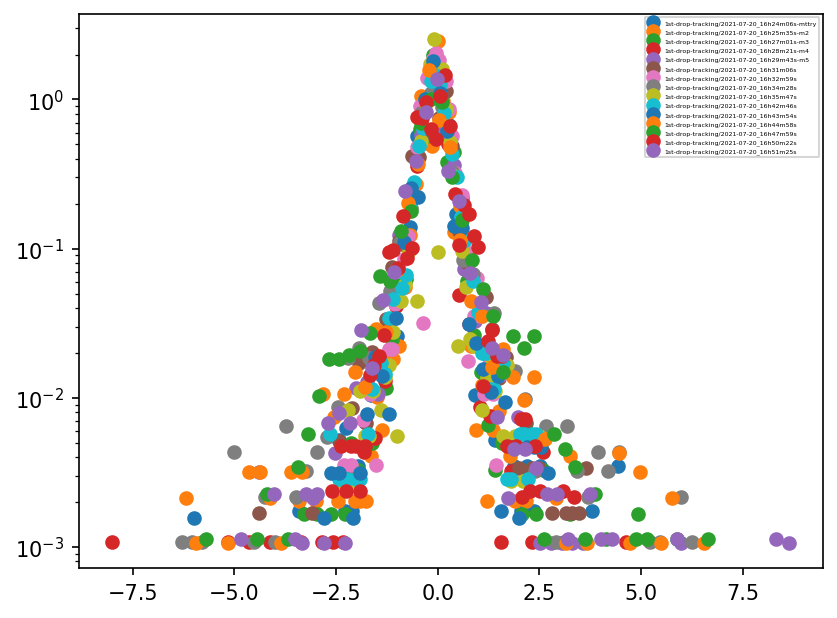

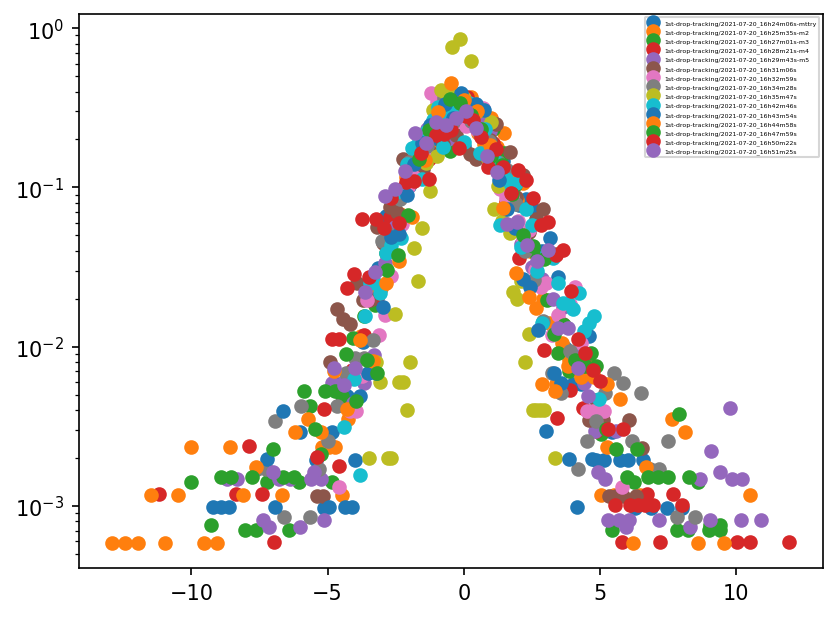

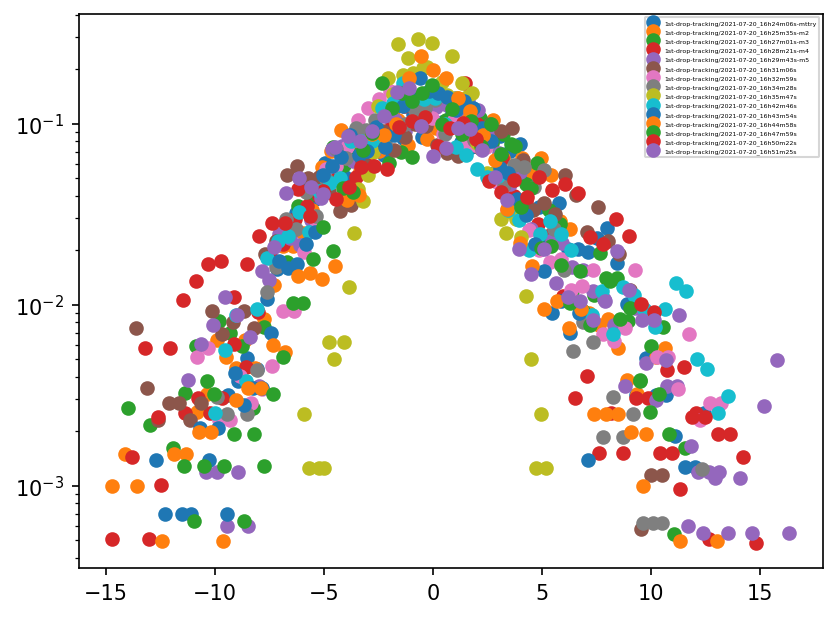

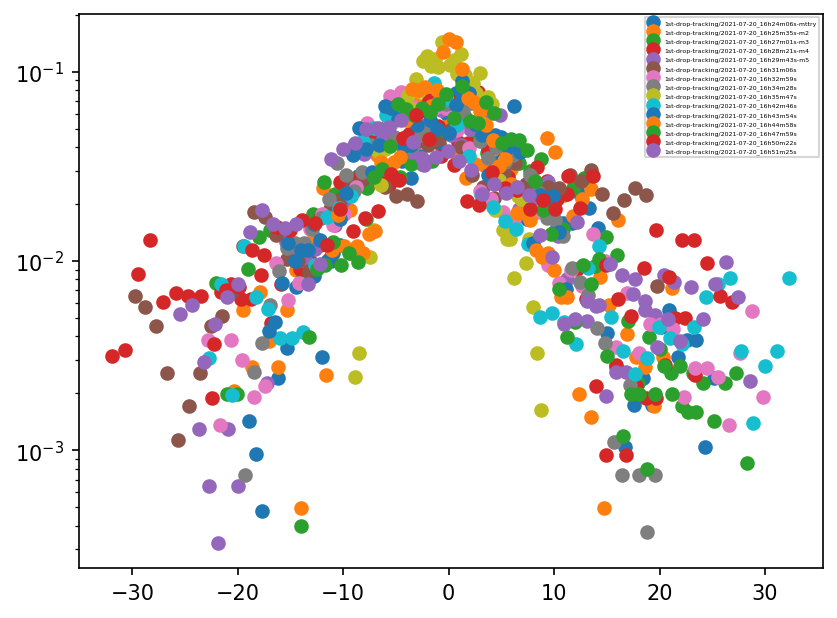

In [61]:
log = pd.read_csv('../../Data/main_log.csv', header=[0, 1])
slog = log.loc[log[('params', 'Date')]==7202021]
folder = '/home/zhengyang/data/DE'

for dt in [1, 10, 30, 90]:
    fig, ax = plt.subplots(dpi=150)
    
    for num, i in slog.iterrows():
        date = '{:08d}'.format(i[('params', 'Date')])
        subfolder = i[('params', 'Subfolder')]
        traj = pd.read_csv(os.path.join(folder, date, subfolder, 'crop_HoughCircles', 'xyz-traj.csv'))
        dx = traj.x.diff(dt)
        dy = traj.y.diff(dt)
        hist, bin_edges = np.histogram(pd.concat([dx, dy]).dropna(), bins=50, density=True)
        ax.plot(bin_edges[:-1], hist, ls='', marker='o', label=subfolder)
        ax.set_yscale('log')
        
#     ax.set_ylim([0.5, 1000])
    ax.legend(fontsize=3)
#     popt, pcov = curve_fit(gauss1, bin_edges[:-1], hist)
#     ax.plot(bin_edges[:-1], gauss1(bin_edges[:-1], *popt))

**Comments**

- PDFs are characterized by a Gaussian core and non-Gaussian tails
- PDFs get wider with increasing dt
- PDFs are similar for same dt, it's reasonable to average 

### Compare PDFs for different parameters (size ratio, inner size, ...)

- fix dt at 0.33 s

##### 1. Based on the size ratio between outer and inner droplets

In [68]:
r = log[('analysis', 'OD')] / log[('analysis', 'ID')]
r.max(), r.min()

(8.535714285714286, 1.847422680412371)

Groups: (0, 3), (3, 5), (5, 7), (7, 9)

Text(0.5, 1.0, 'ratio')

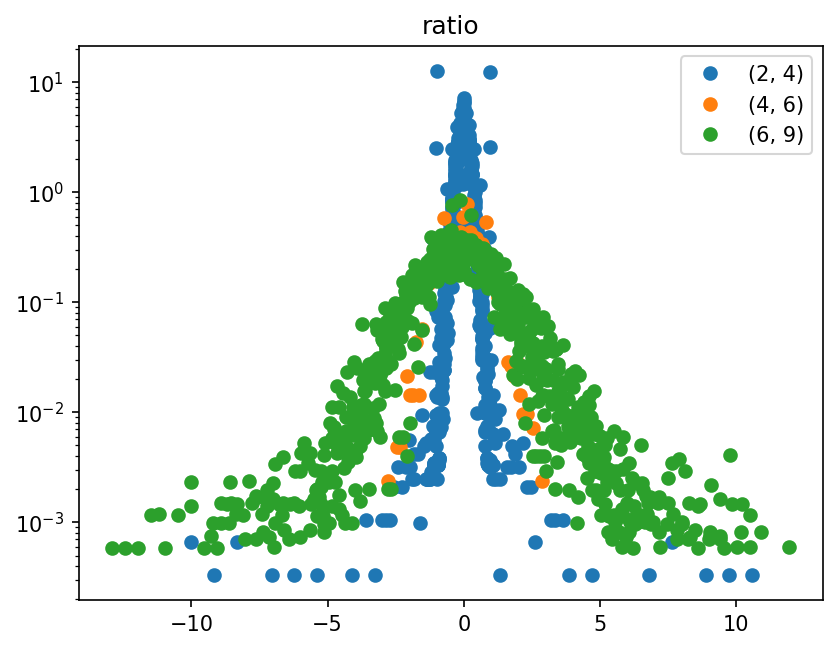

In [92]:
lims = [(2, 4), (4, 6), (6, 9)]
dt = 10
folder = '/home/zhengyang/data/DE'
fig, ax = plt.subplots(dpi=150)
h = {}
for c, lim in enumerate(lims):
    slog = log.loc[(r>lim[0])&(r<=lim[1])&(log[('analysis', '3D-trajectory')]==1)]
    for num, i in slog.iterrows():
        date = '{:08d}'.format(i[('params', 'Date')])
        subfolder = i[('params', 'Subfolder')]
        traj = pd.read_csv(os.path.join(folder, date, subfolder, 'crop_HoughCircles', 'xyz-traj.csv'))
        dx = traj.x.diff(dt)
        dy = traj.y.diff(dt)
        hist, bin_edges = np.histogram(pd.concat([dx, dy]).dropna(), bins=50, density=True)
        h[c], = ax.plot(bin_edges[:-1], hist, ls='', marker='o', label=subfolder, color=bestcolor(c))
        ax.set_yscale('log')
ax.legend([h[0], h[1], h[2]], lims)
ax.set_title('ratio')

##### 2. Inner droplet size

Text(0.5, 1.0, 'inner drop diameter')

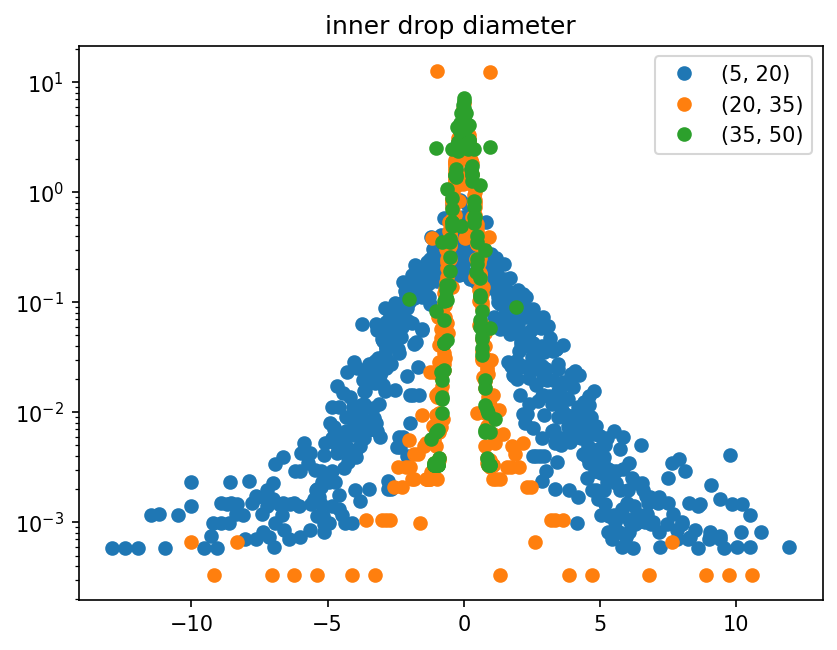

In [95]:
lims = [(5, 20), (20, 35), (35, 50)]
dt = 10
folder = '/home/zhengyang/data/DE'
fig, ax = plt.subplots(dpi=150)
h = {}
for c, lim in enumerate(lims):
    slog = log.loc[(log[('analysis', 'ID')]>lim[0])&(log[('analysis', 'ID')]<=lim[1])&(log[('analysis', '3D-trajectory')]==1)]
    for num, i in slog.iterrows():
        date = '{:08d}'.format(i[('params', 'Date')])
        subfolder = i[('params', 'Subfolder')]
        traj = pd.read_csv(os.path.join(folder, date, subfolder, 'crop_HoughCircles', 'xyz-traj.csv'))
        dx = traj.x.diff(dt)
        dy = traj.y.diff(dt)
        hist, bin_edges = np.histogram(pd.concat([dx, dy]).dropna(), bins=50, density=True)
        h[c], = ax.plot(bin_edges[:-1], hist, ls='', marker='o', label=subfolder, color=bestcolor(c))
        ax.set_yscale('log')
ax.legend([h[0], h[1], h[2]], lims)
ax.set_title('inner drop diameter')

In [93]:
log

params                                                              \
       Date                                     Subfolder  BC   MPP FPS   
0   7132021                          2021-07-13_17h17m24s  20  0.10  30   
1   7202021  1st-drop-tracking/2021-07-20_16h24m06s-mttry  32  0.10  30   
2   7202021     1st-drop-tracking/2021-07-20_16h25m35s-m2  32  0.10  30   
3   7202021     1st-drop-tracking/2021-07-20_16h27m01s-m3  32  0.10  30   
4   7202021     1st-drop-tracking/2021-07-20_16h28m21s-m4  32  0.10  30   
5   7202021     1st-drop-tracking/2021-07-20_16h29m43s-m5  32  0.10  30   
6   7202021        1st-drop-tracking/2021-07-20_16h31m06s  32  0.10  30   
7   7202021        1st-drop-tracking/2021-07-20_16h32m59s  32  0.10  30   
8   7202021        1st-drop-tracking/2021-07-20_16h34m28s  32  0.10  30   
9   7202021        1st-drop-tracking/2021-07-20_16h35m47s  32  0.10  30   
10  7202021        1st-drop-tracking/2021-07-20_16h42m46s  32  0.10  30   
11  7202021        1st-drop-tracking/2021-07-20_16h43m54s  32  0.10  30   
12  7202021        1st-drop-tracking/2021-07-20_16h44m58s  32  0.10  30   
13  7202021        1st-drop-tracking/2021-07-20_16h47m59s  32  0.10  30   
14  7202021        1st-drop-tracking/2021-07-20_16h50m22s  32  0.10  30   
15  7202021        1st-drop-tracking/2021-07-20_16h51m25s  32  0.10  30   
16  7212021                          2021-07-21_16h41m52s  23  0.16  30   
17  7212021                          2021-07-21_16h43m03s  23  0.16  30   
18  8042021                          2021-08-04_16h32m08s  24  0.10  30   
19  8042021                          2021-08-04_16h37m16s  24  0.10  30   
20  8122021                          2021-08-12_16h41m05s  23  0.10  30   
21  8122021                          2021-08-12_16h44m01s  23  0.10  30   
22  8122021                          2021-08-12_16h47m32s  23  0.10  30   
23  8122021                          2021-08-12_16h53m13s  23  0.10  30   
24  8132021                          2021-08-13_15h28m24s  24  0.10  30   
25  8132021                          2021-08-13_15h31m03s  24  0.10  30   
26  8132021                          2021-08-13_15h34m17s  24  0.10  30   
27  8132021                          2021-08-13_15h38m55s  24  0.10  30   
28  8132021                          2021-08-13_15h50m58s  24  0.10  30   
29  8132021                          2021-08-13_15h56m31s  24  0.10  30   
30  8132021                          2021-08-13_16h02m57s  24  0.10  30   
31  8132021                          2021-08-13_16h05m45s  24  0.10  30   
32  8132021                          2021-08-13_16h08m55s  24  0.10  30   
33  8132021                          2021-08-13_16h12m54s  24  0.10  30   
34  8132021                          2021-08-13_16h15m21s  24  0.10  30   
35  8132021                          2021-08-13_16h20m05s  24  0.10  30   
36  8132021                          2021-08-13_16h22m52s  24  0.10  30   
37  8132021                          2021-08-13_16h26m25s  24  0.10  30   
38  8132021                          2021-08-13_16h35m25s  24  0.10  30   

   analysis                                                      Visual  \
         ID     OD     a     b   c 2D-trajectory 3D-trajectory 2D-image   
0      34.5  100.5  45.4  49.0 NaN           1.0           1.0      1.0   
1       8.8   66.0  51.4  51.2 NaN           1.0           1.0      1.0   
2       9.0   69.5  51.3  52.0 NaN           1.0           1.0      1.0   
3       9.0   69.2  50.9  51.8 NaN           1.0           1.0      1.0   
4       9.1   69.3  51.2  51.2 NaN           1.0           1.0      1.0   
5       8.6   65.2  51.7  51.7 NaN           1.0           1.0      1.0   
6       8.9   65.5  51.7  51.0 NaN           1.0           1.0      1.0   
7       9.2   67.7  51.7  51.2 NaN           1.0           1.0      1.0   
8       8.7   67.6  51.5  51.3 NaN           1.0           1.0      1.0   
9       8.9   65.1  52.2  51.4 NaN           1.0           1.0      1.0   
10      8.4   71.7  51.8  51.

In [39]:
log = pd.read_csv('../../Data/main_log.csv', header=[0, 1])
slog = log.loc[log[('params', 'Date')]==7202021]
slog

params                                                             \
       Date                                     Subfolder  BC  MPP FPS   
1   7202021  1st-drop-tracking/2021-07-20_16h24m06s-mttry  32  0.1  30   
2   7202021     1st-drop-tracking/2021-07-20_16h25m35s-m2  32  0.1  30   
3   7202021     1st-drop-tracking/2021-07-20_16h27m01s-m3  32  0.1  30   
4   7202021     1st-drop-tracking/2021-07-20_16h28m21s-m4  32  0.1  30   
5   7202021     1st-drop-tracking/2021-07-20_16h29m43s-m5  32  0.1  30   
6   7202021        1st-drop-tracking/2021-07-20_16h31m06s  32  0.1  30   
7   7202021        1st-drop-tracking/2021-07-20_16h32m59s  32  0.1  30   
8   7202021        1st-drop-tracking/2021-07-20_16h34m28s  32  0.1  30   
9   7202021        1st-drop-tracking/2021-07-20_16h35m47s  32  0.1  30   
10  7202021        1st-drop-tracking/2021-07-20_16h42m46s  32  0.1  30   
11  7202021        1st-drop-tracking/2021-07-20_16h43m54s  32  0.1  30   
12  7202021        1st-drop-tracking/2021-07-20_16h44m58s  32  0.1  30   
13  7202021        1st-drop-tracking/2021-07-20_16h47m59s  32  0.1  30   
14  7202021        1st-drop-tracking/2021-07-20_16h50m22s  32  0.1  30   
15  7202021        1st-drop-tracking/2021-07-20_16h51m25s  32  0.1  30   

   analysis                                                     Visual  \
         ID    OD     a     b   c 2D-trajectory 3D-trajectory 2D-image   
1       8.8  66.0  51.4  51.2 NaN           1.0           1.0      1.0   
2       9.0  69.5  51.3  52.0 NaN           1.0           1.0      1.0   
3       9.0  69.2  50.9  51.8 NaN           1.0           1.0      1.0   
4       9.1  69.3  51.2  51.2 NaN           1.0           1.0      1.0   
5       8.6  65.2  51.7  51.7 NaN           1.0           1.0      1.0   
6       8.9  65.5  51.7  51.0 NaN           1.0           1.0      1.0   
7       9.2  67.7  51.7  51.2 NaN           1.0           1.0      1.0   
8       8.7  67.6  51.5  51.3 NaN           1.0           1.0      1.0   
9       8.9  65.1  52.2  51.4 NaN           1.0           1.0      1.0   
10      8.4  71.7  51.8  51.4 NaN           1.0           1.0      1.0   
11      8.9  65.8  52.1  51.6 NaN           1.0           1.0      1.0   
12      9.2  66.4  52.4  50.4 NaN           1.0           1.0      1.0   
13      9.0  68.9  52.5  51.8 NaN           1.0           1.0      1.0   
14      9.6  70.8  51.3  51.2 NaN           1.0           1.0      1.0   
15      9.5  70.1  51.2  51.0 NaN           1.0           1.0      1.0   

                            
   3D-projection 3D-outRef  
1            1.0       1.0  
2            1.0       1.0  
3            1.0       1.0  
4            1.0       1.0  
5            1.0       1.0  
6            1.0       1.0  
7            1.0       1.0  
8            0.0       0.0  
9            0.0       0.0  
10           1.0       1.0  
11           0.0       0.0  
12           0.0       0.0  
13           0.0       0.0  
14           0.0       0.0  
15           1.0       0.0